# Identifying volcanoes on Venus

We're going to use images collected by the [Magellan mission](https://www2.jpl.nasa.gov/magellan/) to build a classifier that's able to identify volanoes on Venus.  The data we will use consist of thousands of `110x110` pixel images of the surface.  The raw images can be found on NASA's website, but we'll save ourselves some work by using the processed "chip" images hosted on `kaggle`.

The easiest way to download the data is to log into kaggle, go to your account, and generate an API key.  Once you've created this, you can download the `kagle.json` file and move it into a `.kaggle` directory in your docker container home directory.

After running `pip install kaggle`, you should be able to run the cell below to download the data.

In [1]:
!pip install --quiet kaggle

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
!kaggle datasets download -d fmena14/volcanoesvenus
!unzip -o volcanoesvenus.zip

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
volcanoesvenus.zip: Skipping, found more recently modified local copy (use --force to force download)
overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
Archive:  volcanoesvenus.zip
  inflating: Volcanoes_test/test_images.csv  
  inflating: Volcanoes_test/test_labels.csv  
  inflating: Volcanoes_train/train_images.csv  
  inflating: Volcanoes_train/train_labels.csv  
  inflating: volcanoes_test/test_images.csv  
  inflating: volcanoes_test/test_labels.csv  
  inflating: volcanoes_train/train_images.csv  
  inflating: volcanoes_train/train_labels.csv  


Then unzip the archive.

Let's load the images and labels.

In [3]:
import pandas as pd
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [4]:
from time import time
import datetime

from flax import linen as nn

In [5]:
import os

In [6]:
!head -n2 Volcanoes_train/train_images.csv

overwriting variable {'LAL_DATA_PATH'}
Exported key ADS_API_TOKEN
95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,111,108,94,95,97,108,96,92,89,95,101,94,56,61,90,101,92,101,110,102,104,116,112,95,95,90,110,109,90,97,101,101,92,79,77,96,89,91,97,101,98,89,95,107,113,99,78,93,102,99,98,105,103,107,112,94,79,84,103,104,103,103,114,125,111,95,99,87,90,93,77,75,84,104,100,90,99,93,79,101,99,86,76,80,87,98,108,95,72,91,98,82,97,104,102,99,91,86,101,99,97,91,95,93,103,104,104,96,106,112,108,106,105,107,112,109,100,96,90,99,109,102,87,96,99,108,103,84,98,96,79,87,98,100,103,96,102,102,98,100,112,100,91,100,109,95,105,103,116,124,116,105,97,109,123,115,84,104,102,100,87,95,92,87,100,86,80,90,92,95,103,101,104,104,109,118,108,91,79,84,95,94,89,102,106,99,92,94,106,101,89,90,70,78,103,95,89,80,82,86,97,95,105,112,97,95,100,94,103,92,97,101,103,98,102,101,88,72,86,94,103,90,110,118,116,112,99,91,88,89,81,96,

It doesn't look like there's a header.

In [7]:
train_images = pd.read_csv('Volcanoes_train/train_images.csv', header=None)
test_images = pd.read_csv('Volcanoes_test/test_images.csv', header=None)
train_labels = pd.read_csv('Volcanoes_train/train_labels.csv')
test_labels = pd.read_csv('Volcanoes_test/test_labels.csv')

In [8]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


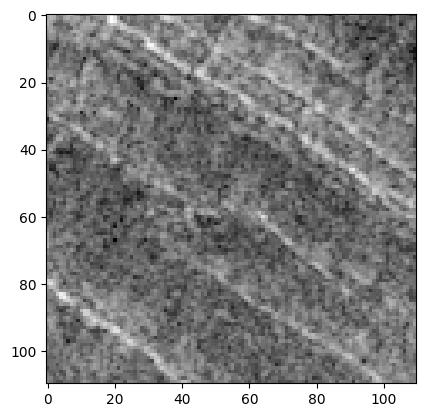

In [9]:
image = np.array(train_images.iloc[82]).reshape((110, 110))
plt.imshow(image, cmap="gray");

In [10]:
train_labels.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


It looks like `NaN`s populate the fields other than `Volvano?` when there aren't any volcanoes in the image.  Let's replace them with `0`s to save ourselves potential headaches in the future.

In [11]:
train_labels.fillna(value=0, inplace=True)
test_labels.fillna(value=0, inplace=True)
train_labels.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,0.0,0.00,0.0
2,0,0.0,0.00,0.0
3,0,0.0,0.00,0.0
4,0,0.0,0.00,0.0


👍

Now let's build our design matrices, rescale them, and collect our results.

In [12]:
X_train = np.array(train_images, dtype=float).reshape(train_images.shape[0], 110, 110, 1)
X_test = np.array(test_images, dtype=float).reshape(test_images.shape[0], 110, 110, 1)

In [13]:
X_train /= 255
X_test /= 255

We could treat this as a multi-class classification problem and learn how to count volcanoes, but for now let's just learn how to identify at least one volcano.

In [14]:
target = 'Volcano?'
ncats = 2

Y_train = train_labels[target]
Y_test = test_labels[target]

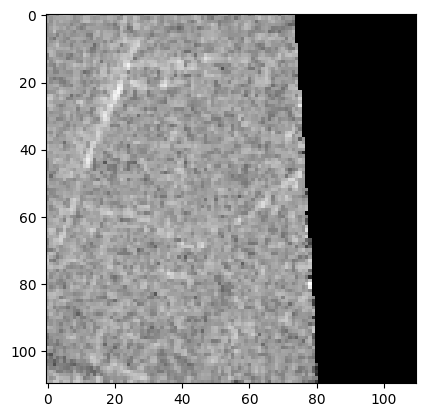

In [15]:
plt.imshow(X_train[63, :, :, 0], cmap='gray');

It looks like some images in the data set are corrupted.  Let's remove any images that have more than $10\%$ pixels at `0`.

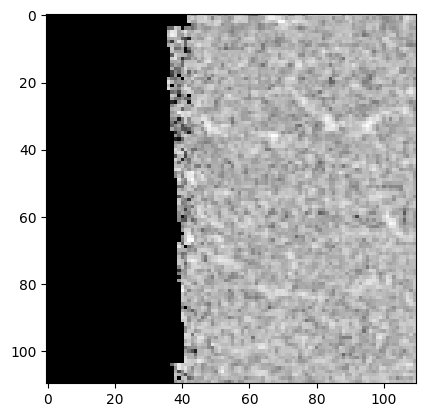

In [16]:
corrupted_train_images = np.mean(X_train == 0, axis=(1, 2)).flatten() > .1
corrupted_test_images = np.mean(X_test == 0, axis=(1, 2)).flatten() > .1
plt.imshow(X_train[corrupted_train_images][1, :, :, 0], cmap='gray');

In [17]:
X_train = jnp.array(X_train[~corrupted_train_images])
X_test = jnp.array(X_test[~corrupted_test_images])
Y_train = jnp.array(Y_train[~corrupted_train_images].astype(int))
Y_test = jnp.array(Y_test[~corrupted_test_images].astype(int))

In [18]:
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
Y_train = Y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *Y_train.shape[1:]))

n_test_batches = X_test.shape[0] // batch_size
X_test = X_test[:n_test_batches * batch_size].reshape((n_test_batches, batch_size, *X_test.shape[1:]))
Y_test = Y_test[:n_test_batches * batch_size].reshape((n_test_batches, batch_size, *Y_test.shape[1:]))

X_train.shape, Y_train.shape

((105, 64, 110, 110, 1), (105, 64))

Now let's build a CNN and train it.

Below is one example of a successful CNN architecture from Behcet Senturk [on kaggle](https://www.kaggle.com/behcetsenturk/finding-volcanoes-with-cnn).

In [16]:
# model = tf.keras.Sequential()
# model.add(layers.Conv2D(filters=2, kernel_size=(3, 3), padding='same',
#                  activation='relu', input_shape=(110, 110, 1)))
# model.add(layers.Conv2D(filters=4, kernel_size=(3, 3),
#                  padding='same', activation='relu'))
# model.add(layers.Conv2D(filters=8, kernel_size=(5, 5),
#                  padding='same',activation ='relu'))
# model.add(layers.MaxPool2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(filters=16, kernel_size=(5,5),
#                  padding='same', activation ='relu'))
# model.add(layers.MaxPool2D(pool_size=(2, 2)))
# model.add(layers.Conv2D(filters=24, kernel_size=(7, 7),
#                  padding='same', activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
# model.add(layers.Dense(Y_train.shape[1], activation="softmax"))

In [19]:
class ConvNN(nn.Module):
  """A simple model with densely connected layers."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)
    x = nn.relu(x)
    x = nn.Dense(ncats)(x)
    return x

In [20]:
import jax
import jax.numpy as jnp  # JAX NumPy
dummy_input = jnp.ones((1, 110, 110, 1))
cnn = ConvNN()
print(cnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                                 ConvNN Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ ConvNN │ float32[1,110,11… │ float32[1,2]      │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,110,11… │ float32[1,110,11… │ bias: float32[64] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,64] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 640 (2.6 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Dense_0 │ Dense  │ float3

In [21]:
init_rng = jax.random.PRNGKey(0)

In [22]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [23]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(cnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [27]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [24]:
n_epochs = 3

In [28]:
from tqdm import tqdm

In [31]:
step = 0

for _ in range(n_epochs):
  for batch, label in tqdm(zip(X_train, Y_train), total=n_batches):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      i = np.random.randint(X_test.shape[0])
      test_state = compute_metrics(state=test_state, batch=X_test[i], label=Y_test[i])

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

100%|██████████| 105/105 [01:08<00:00,  1.54it/s]


train epoch: 1, loss: 8.631181716918945, accuracy: 84.70419311523438
test epoch: 1, loss: 0.32614463567733765, accuracy: 82.8125


100%|██████████| 105/105 [01:06<00:00,  1.58it/s]


train epoch: 2, loss: 0.17539487779140472, accuracy: 94.61309051513672
test epoch: 2, loss: 0.27582183480262756, accuracy: 87.5


100%|██████████| 105/105 [01:08<00:00,  1.54it/s]

train epoch: 3, loss: 0.07282809913158417, accuracy: 97.91667175292969
test epoch: 3, loss: 0.4117691218852997, accuracy: 89.0625


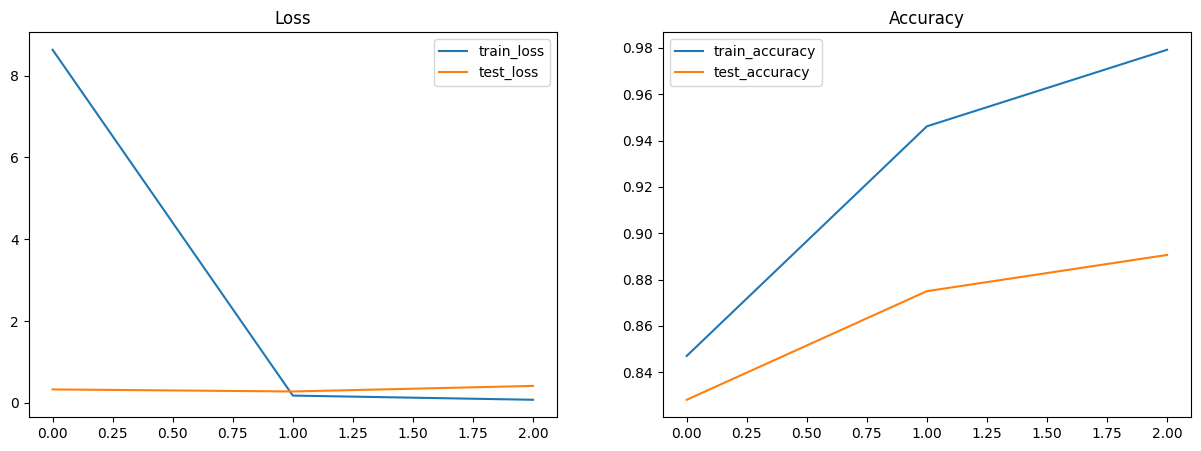

<Figure size 640x480 with 0 Axes>

In [32]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [37]:
@jax.jit
def predict(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

Now let's perform some of the same checks we've done in the past, e.g., generate a confusion matrix, look at some of the best and worst predictions, etc.

In [49]:
state.apply_fn({'params': state.params}, X_test[0]), Y_test[0]

(Array([[ 1.3539418 , -0.92028415],
        [ 2.4110308 , -2.5837085 ],
        [-0.60360634, -0.28472638],
        [ 2.0613708 , -2.3728163 ],
        [-2.8218236 ,  2.0755043 ],
        [ 0.3868993 , -0.7414188 ],
        [ 2.8429813 , -2.6309059 ],
        [ 1.3765401 , -1.3765941 ],
        [ 2.009861  , -2.83719   ],
        [ 2.4612591 , -2.3036683 ],
        [ 1.7573868 , -1.548148  ],
        [ 0.83332   , -1.1197267 ],
        [ 3.1313992 , -2.1190212 ],
        [ 0.9468508 , -1.1242174 ],
        [-0.99126714, -0.05920377],
        [ 5.784132  , -5.8661065 ],
        [ 1.6165164 , -1.452845  ],
        [ 0.69253093, -0.65189016],
        [ 2.0761638 , -1.472726  ],
        [-0.6917392 ,  0.14030688],
        [ 2.9045608 , -2.9083908 ],
        [ 1.1659026 , -1.4872018 ],
        [ 2.3923886 , -2.1831875 ],
        [ 1.5378716 , -1.0614879 ],
        [ 1.7168783 , -1.6037538 ],
        [ 3.6107073 , -4.003477  ],
        [ 0.5479221 , -0.76160187],
        [ 1.6467972 , -1.683

In [54]:
def check(state, batch, labels):
    logits = state.apply_fn({'params': state.params}, batch)
    pred = predict(state, batch)

    confusion_matrix = np.zeros((ncats, ncats))
    for truth, guess in zip(labels, pred):
        confusion_matrix[truth, guess] += 1

    plt.imshow(confusion_matrix)
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.show()

    print("Number of incorrect guesses: ", np.sum(pred != labels), " of ", len(batch))

    predictions_for_true_values = [logit[i] for logit, i in zip(logits, labels)]

    bins = plt.hist(predictions_for_true_values, bins=30, range=(0, 1))
    plt.title("Output for correct classes")

    volcano = np.arange(len(label))[label == 1]

    worst = np.argsort(predictions_for_true_values)
    plt.show()

    print("Worst:")
    for index in worst[:5]:
        print("Guess: ", pred[index], ' truth: ', labels[index])
        plt.imshow(np.squeeze(batch[index]), cmap='gray')
        plt.show()

    print("Best:")
    for index in worst[-5:]:
        print("Guess: ", pred[index], ' truth: ', labels[index])
        plt.imshow(np.squeeze(batch[index]), cmap='gray')
        plt.show()

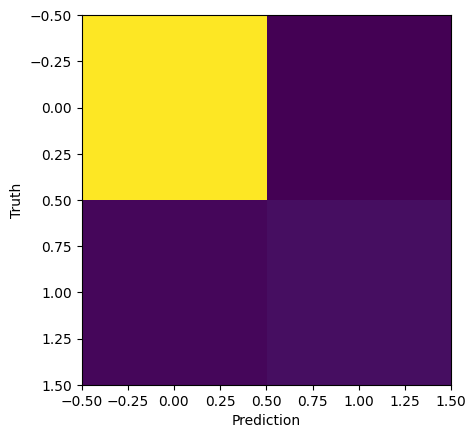

Number of incorrect guesses:  5  of  64


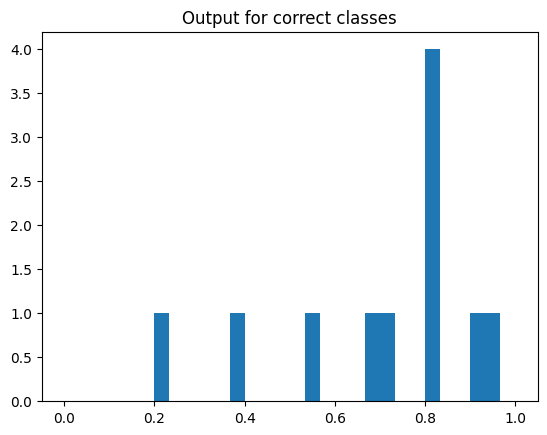

Worst:
Guess:  0  truth:  1


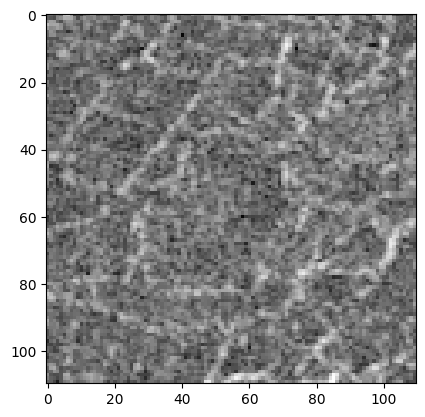

Guess:  1  truth:  0


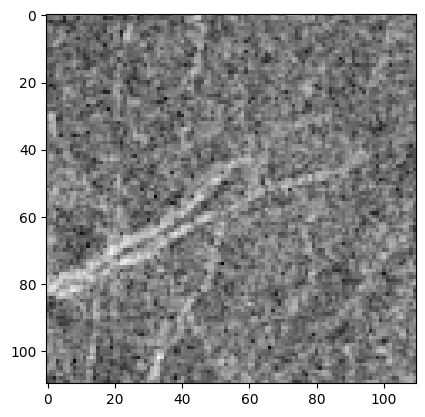

Guess:  0  truth:  1


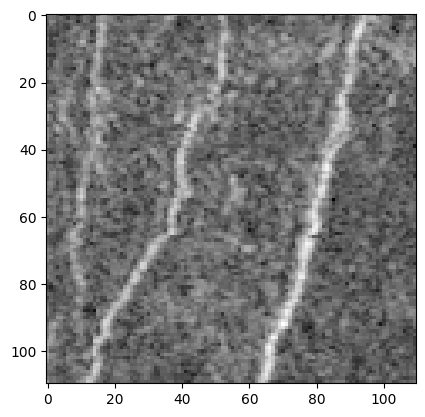

Guess:  1  truth:  0


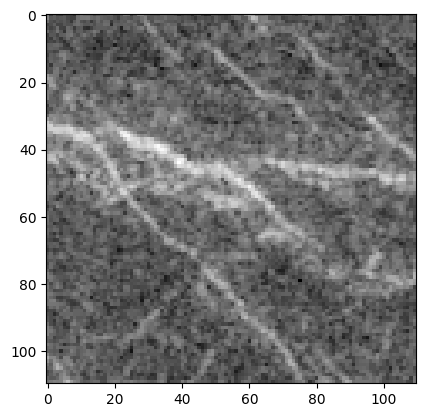

Guess:  0  truth:  1


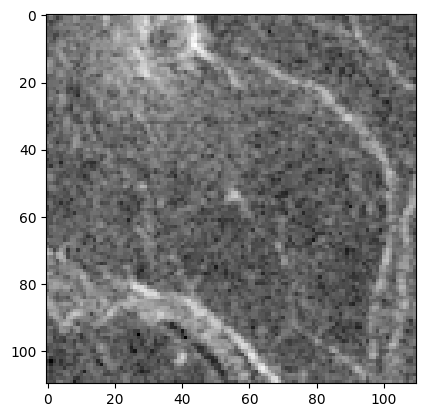

Best:
Guess:  0  truth:  0


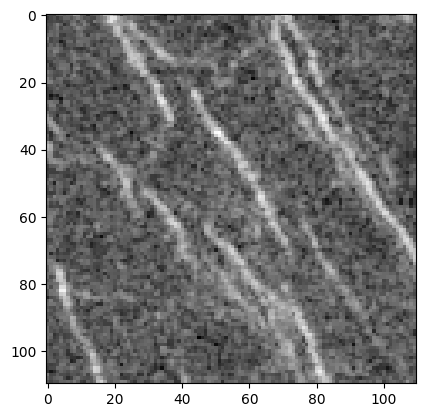

Guess:  0  truth:  0


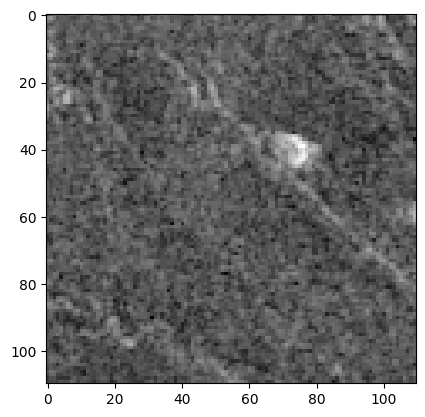

Guess:  0  truth:  0


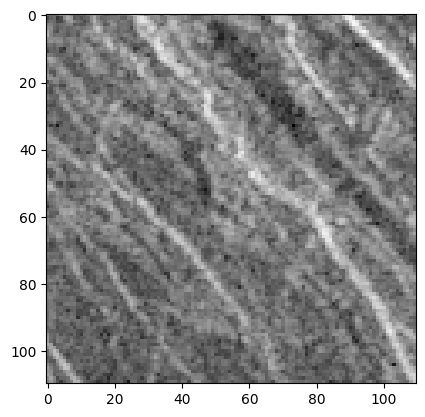

Guess:  0  truth:  0


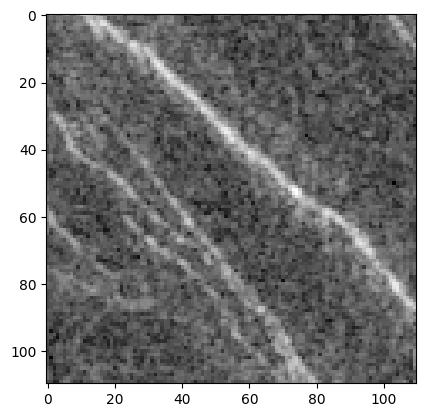

Guess:  0  truth:  0


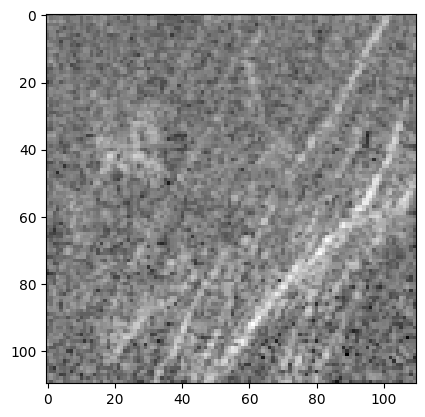

In [55]:
check(state, X_test[0], Y_test[0])